In [ ]:
# This is a code block from GOSDT with Guesses included so that the cut function can
# be called later to reuse the thresholds
import numpy as np
import pandas as pd
import json
import time
import random
import sys
import os
from queue import Queue
import pathlib

from math import ceil
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics


# fit the tree using gradient boosted classifier
def fit_boosted_tree(X, y, n_est=10, lr=0.1, d=1):
    clf = GradientBoostingClassifier(loss='log_loss',
                                     learning_rate=lr,
                                     n_estimators=n_est,
                                     max_depth=d,
                                     random_state=42)
    clf.fit(X, y)
    out = clf.score(X, y)
    return clf, out


# perform cut on the dataset
def cut(X, ts):
    df = X.copy()
    colnames = X.columns
    for j in range(len(ts)):
        for s in range(len(ts[j])):
            # Create column to store binary values set all to 1
            X[colnames[j]+'<='+str(ts[j][s])] = 1
            # Create mask of observations greater than threshold
            k = df[colnames[j]] > ts[j][s]
            # All observations greater than threshold set to 0
            X.loc[k, colnames[j]+'<='+str(ts[j][s])] = 0
        # Drop feature column after iterating through
        X = X.drop(colnames[j], axis=1)
    # Return a df of all thresholds for each feature binarized
    return X


# Compute the thresholds for Guessing
def get_thresholds(X, y, n_est, lr, d, backselect=True):
    # flatten the array
    y = np.ravel(y)
    # call the fit_boosted_tree function which takes a df X,
    # its class labels y, the number of estimator trees n_est,
    # the learning rate lr, and the max depth d and trains a
    # Gradient Boosting Classifier returning the accuracy and
    # classifier object, backselect removes all but the most
    # accurate threshold for each feature
    clf, out = fit_boosted_tree(X, y, n_est, lr, d)
    # Create an empty list to store lists of threshold values
    # for each feature
    thresholds = []
    # Loop through the columns in X
    for j in range(X.shape[1]):
        # Empty the array for storing estimator threshold values
        tj = np.array([])
        # Iterate through all estimator trees in the black box
        for i in range(len(clf.estimators_)):
            # Store the array of features for each estimator tree
            # (at depth 1, 1 feature)
            f = clf.estimators_[i,0].tree_.feature
            # Store the array of threshold values for each estimator tree
            t = clf.estimators_[i,0].tree_.threshold
            # Append the threshold value to tj if its the current feature
            # in X (j)
            tj = np.append(tj, t[f==j])
        # Remove duplicate threshold values for the current feature
        tj = np.unique(tj)
        # Append the list of thresholds for the current feature to threshold list
        thresholds.append(tj.tolist())
    # Create a binarized df with all thresholds used in black box estimators
    X_new = cut(X, thresholds)
    clf1, out1 = fit_boosted_tree(X_new, y, n_est, lr, d)

    # Set starting accuracy comparison to 1
    outp = 1
    # Copy the black box threshold binarized df
    Xp = X_new.copy()
    # Copy the classifier trained on the binarized data
    clfp = clf1
    # set column tracker to 0
    itr=0
    if backselect:
        # Iterate while there is no drop in accuracy from removing the lowest importance variable
        # compared to the tree trained on all threshold splits (or you run out of columns to drop)
        while outp >= out1 and itr < X_new.shape[1]-1:
            # Get variable importance array from black box
            vi = clfp.feature_importances_
            # Check if there is at least 1 variable importance value
            if vi.size > 0:
                # Get the columns in Xp
                c = Xp.columns
                # Get index of lowest importance variable
                i = np.argmin(vi)
                # Drop lowest importance variable
                Xp = Xp.drop(c[i], axis=1)
                # Retrain/fit black box on reduced data
                clfp, outp = fit_boosted_tree(Xp, y, n_est, lr, d)
                # Increment the iteration counter
                itr += 1
            # Loop will break once the accuracy is reduced below the baseline
            # accuracy from removing variables or if there are no variables left to reduce
            else:
                break
        # Copy the reduced feature set
        Xp[c[i]] = X_new[c[i]]
        #_, _ = fit_boosted_tree(Xp, y, n_est, lr, d)

    h = Xp.columns
    #print('features:', h)
    return Xp, thresholds, h

# compute the thresholds
def compute_thresholds(X, y, n_est, max_depth) :
    # n_est, max_depth: GBDT parameters
    # set LR to 0.1
    lr = 0.1
    start = time.perf_counter()
    X, thresholds, header = get_thresholds(X, y, n_est, lr, max_depth, backselect=True)
    guess_time = time.perf_counter()-start
    return X, thresholds, header, guess_time


In [ ]:
pip install pydotplus

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import statements, note some of the data cleaning imports aren't needed for this dataset
import pandas as pd
import numpy as np
import pathlib
import gosdt
import time
from sklearn.ensemble import GradientBoostingClassifier
# from imblearn.over_sampling import SMOTE
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import Binarizer


In [ ]:
# Read in the csv for the Wisconsin Breast Cancer Dataset
df = pd.read_csv("heart_diseases_guesses.csv")
print(df)
# Create a list of the table headers to be used to add headers to training/testing datasets
h = df.columns[:-1]
# Create a series of ground truth target classes
y = df['num']
# Drop the target class column to separate the features
X = df.drop(columns=['num'])


     age  trestbps  chol  fbs  thalch  exang  oldpeak  ca  Heart rate  \
0     63       145   233    1     150      0      2.3   0          66   
1     67       160   286    0     108      1      1.5   3          94   
2     67       120   229    0     129      1      2.6   2          64   
3     37       130   250    0     187      0      3.5   0          70   
4     41       130   204    0     172      0      1.4   0          64   
..   ...       ...   ...  ...     ...    ...      ...  ..         ...   
294   68       144   193    1     141      0      3.4   2          61   
295   57       130   131    0     115      1      1.2   1          74   
296   57       130   236    0     174      0      0.0   1          61   
297   47       150   226    0      98      1      1.5   0          80   
298   56       120   100    0     120      1      1.5   0          83   

     Systolic blood pressure  ...  restecg_lv hypertrophy  restecg_normal  \
0                        160  ...             

In [ ]:
# Check the class balance
df['num'].value_counts()

0    160
1    139
Name: num, dtype: int64

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)



In [ ]:
import pandas as pd
import time
import pathlib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import gosdt  # Assuming you have the GOSDT library

# GBDT parameters for threshold and lower bound guesses
n_est = 200
max_depth = 1

# Guess thresholds
X = pd.DataFrame(X_train, columns=h)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Guess thresholds
X_train_g, thresholds, header, threshold_guess_time = compute_thresholds(X_train, y_train, n_est, max_depth)
y_train_g = pd.DataFrame(y_train)

# Guess lower bound using Gradient Boosting
start_time = time.time()
clf = GradientBoostingClassifier(n_estimators=n_est, max_depth=max_depth, random_state=42)
clf.fit(X_train_g, y_train_g.values.flatten())
warm_labels = clf.predict(X_train_g)
elapsed_time = time.time() - start_time
lb_time = elapsed_time

# Save the labels from lower bound guesses to a tmp file
labelsdir = pathlib.Path('/tmp/warm_lb_labels')
labelsdir.mkdir(exist_ok=True, parents=True)
labelpath = labelsdir / 'warm_label.tmp'
labelpath = str(labelpath)
pd.DataFrame(warm_labels, columns=["class_labels"]).to_csv(labelpath, header="class_labels", index=None)

# Train GOSDT model
config = {
    "regularization": 0.001,
    "depth_budget": 3,
    "warm_LB": True,
    "path_to_labels": labelpath,
    "similar_support": False
}

model = gosdt.GOSDT(config)
model.fit(X_train_g, y_train_g)

print("Evaluating the model, extracting tree and scores...\n", flush=True)

# Get the results for training accuracy
train_acc = model.score(X_train_g, y_train_g)

# Threshold X_test using the same black-box derived thresholds as the training set
X_test = cut(X_test, thresholds)  # Apply same thresholds to the test set
X_test = X_test[X_train_g.columns]  # Remove unused thresholds

# Calculate test accuracy
test_acc = model.score(X_test, y_test)

# Get number of leaves and nodes in the model
n_leaves = model.leaves()
n_nodes = model.nodes()

# Calculate total training time
fulltime = time.time() - start_time

# Print training time and model structure
print("Model training time: {}".format(fulltime))
print("Training accuracy: {}".format(train_acc))
print("Test accuracy: {}".format(test_acc))
print("# of leaves: {}".format(n_leaves))
print("# of nodes: {}".format(n_nodes))

# Print the confusion matrix of the model (if available)
print("Confusion Matrix (Training Set):")
train_preds = model.predict(X_train_g)
train_cm = confusion_matrix(y_train_g, train_preds)
print(train_cm)

print("Confusion Matrix (Test Set):")
test_preds = model.predict(X_test)
test_cm = confusion_matrix(y_test, test_preds)
print(test_cm)

# Calculate precision, recall, F1 score, and support for the training set
train_prec, train_rec, train_fbeta, train_supp = precision_recall_fscore_support(
    y_train_g, train_preds, average='binary'
)

# Calculate precision, recall, F1 score, and support for the test set
test_prec, test_rec, test_fbeta, test_supp = precision_recall_fscore_support(
    y_test, test_preds, average='binary'
)

# Print metrics in the desired order: Precision, Accuracy, Recall
print("\n--- Training Set Metrics ---")
print(f"Training Precision: {train_prec:.4f}")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training Recall: {train_rec:.4f}")
print(f"Training F1-Score: {train_fbeta:.4f}")
print(f"Training Support: {train_supp}")

print("\n--- Test Set Metrics ---")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1-Score: {test_fbeta:.4f}")
print(f"Test Support: {test_supp}")

# Final output
print("\n--- Final Results ---")
print(f"Model Training Time: {fulltime:.2f} seconds")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"# of Leaves: {n_leaves}")
print(f"# of Nodes: {n_nodes}")
print(f"Confusion Matrix (Training Set):\n{train_cm}")
print(f"Confusion Matrix (Test Set):\n{test_cm}")


X_train shape: (104, 32)
y_train shape: (104,)
gosdt reported successful execution
training completed. 0.000/0.000/0.002 (user, system, wall), mem=0 MB
bounds: [0.153846..0.153846] (0.000000) loss=0.115385, iterations=53
Evaluating the model, extracting tree and scores...

Regularization smaller than 1/(num_samples) - this may lead to longer training time if not adjusted.
Regularization increased to 1/(num_samples) = 0. To allow regularization below this, set allow_small_reg to true
Model training time: 0.1382761001586914
Training accuracy: 0.8846153846153846
Test accuracy: 0.7111111111111111
# of leaves: 4
# of nodes: 7
Confusion Matrix (Training Set):
[[56  0]
 [12 36]]
Confusion Matrix (Test Set):
[[44  4]
 [22 20]]

--- Training Set Metrics ---
Training Precision: 1.0000
Training Accuracy: 0.8846
Training Recall: 0.7500
Training F1-Score: 0.8571
Training Support: None

--- Test Set Metrics ---
Test Precision: 0.8333
Test Accuracy: 0.7111
Test Recall: 0.4762
Test F1-Score: 0.6061
Te

X_train shape: (239, 35)
y_train shape: (239,)
gosdt reported successful execution
training completed. 0.000/0.000/0.213 (user, system, wall), mem=0 MB
bounds: [0.180628..0.180628] (0.000000) loss=0.150628, iterations=4521
Evaluating the model, extracting tree and scores...



KeyError: "None of [Index(['trestbps<=107.0', 'trestbps<=109.0', 'trestbps<=151.0', 'chol<=279.5',\n       'chol<=303.5', 'chol<=318.5', 'thalch<=136.5', 'thalch<=147.5',\n       'thalch<=170.5', 'thalch<=177.5', 'exang<=0.5', 'oldpeak<=0.75',\n       'oldpeak<=2.450000047683716', 'ca<=0.5', 'ca<=1.5', 'Heart rate<=56.5',\n       'Heart rate<=63.5', 'Systolic blood pressure<=129.5',\n       'Systolic blood pressure<=130.5', 'Systolic blood pressure<=140.5',\n       'Systolic blood pressure<=168.5', 'Diastolic blood pressure<=47.0',\n       'Diastolic blood pressure<=64.5', 'Blood sugar<=55.5',\n       'Blood sugar<=384.5', 'CK-MB<=8.399999618530273',\n       'CK-MB<=9.809999942779541', 'Troponin<=0.001500000071246177',\n       'Troponin<=0.015500000212341547', 'sex_Female<=0.5', 'sex_Male<=0.5',\n       'cp_asymptomatic<=0.5', 'slope_flat<=0.5', 'slope_upsloping<=0.5',\n       'thal_normal<=0.5', 'age<=54.5<=0.5', 'age<=63.5<=0.5',\n       'cp_non-anginal<=0.5'],\n      dtype='object')] are in the [columns]"

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Predicting for training and test sets
y_train_pred = model.predict(X_train_g)  # Predictions for the training set
y_test_pred = model.predict(X_test)     # Predictions for the test set

# Calculate precision, recall, F1 score, and support for the training set
prec, rec, fbeta, supp = precision_recall_fscore_support(
    y_train_g, y_train_pred, average='binary'
)

# Calculate precision, recall, F1 score, and support for the test set
prec2, rec2, fbeta2, supp2 = precision_recall_fscore_support(
    y_test, y_test_pred, average='binary'
)

# Print the results for training and test sets
print(f"Training Precision: {prec:.4f}")
print(f"Training Recall: {rec:.4f}")
print(f"Training F1 Score: {fbeta:.4f}")
print(f"Training Support: {supp}")

print(f"Test Precision: {prec2:.4f}")
print(f"Test Recall: {rec2:.4f}")
print(f"Test F1 Score: {fbeta2:.4f}")
print(f"Test Support: {supp2}")

Training Precision: 0.9778
Training Recall: 0.9167
Training F1 Score: 0.9462
Training Support: None
Test Precision: 0.9412
Test Recall: 0.3810
Test F1 Score: 0.5424
Test Support: None


In [ ]:
print(prec2)
print(rec2)
print(fbeta2)

0.5333333333333333
0.24242424242424243
0.3333333333333333


In [ ]:
#Display the confusion matrix for the training and test set
from sklearn.metrics import confusion_matrix
display(confusion_matrix(y_train_g,y_train_pred))
display(confusion_matrix(y_test,y_test_pred))

array([[41,  5],
       [ 6, 31]])

array([[39,  0],
       [32,  1]])

In [ ]:
# Create a fresh df
df = pd.read_csv("heart_diseases_guesses.csv")
h = df.columns[:-1]
y = df['num']
X = df.drop(columns=['num'])

In [ ]:
# Create a fresh train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
# Train a black box Gradient Boosting Decision Tree Classifier to compare to GOSDT
n_est = 250
d = 10
lr = 0.001

clf = GradientBoostingClassifier(loss='log_loss',learning_rate=lr,n_estimators=n_est,max_depth=d,random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
out = clf.score(X_train, y_train)
print(out)

1.0


In [ ]:
# Calculate test accuracy
y_test_pred =  clf.predict(X_test)
print(clf.score(X_test,y_test))

0.7333333333333333


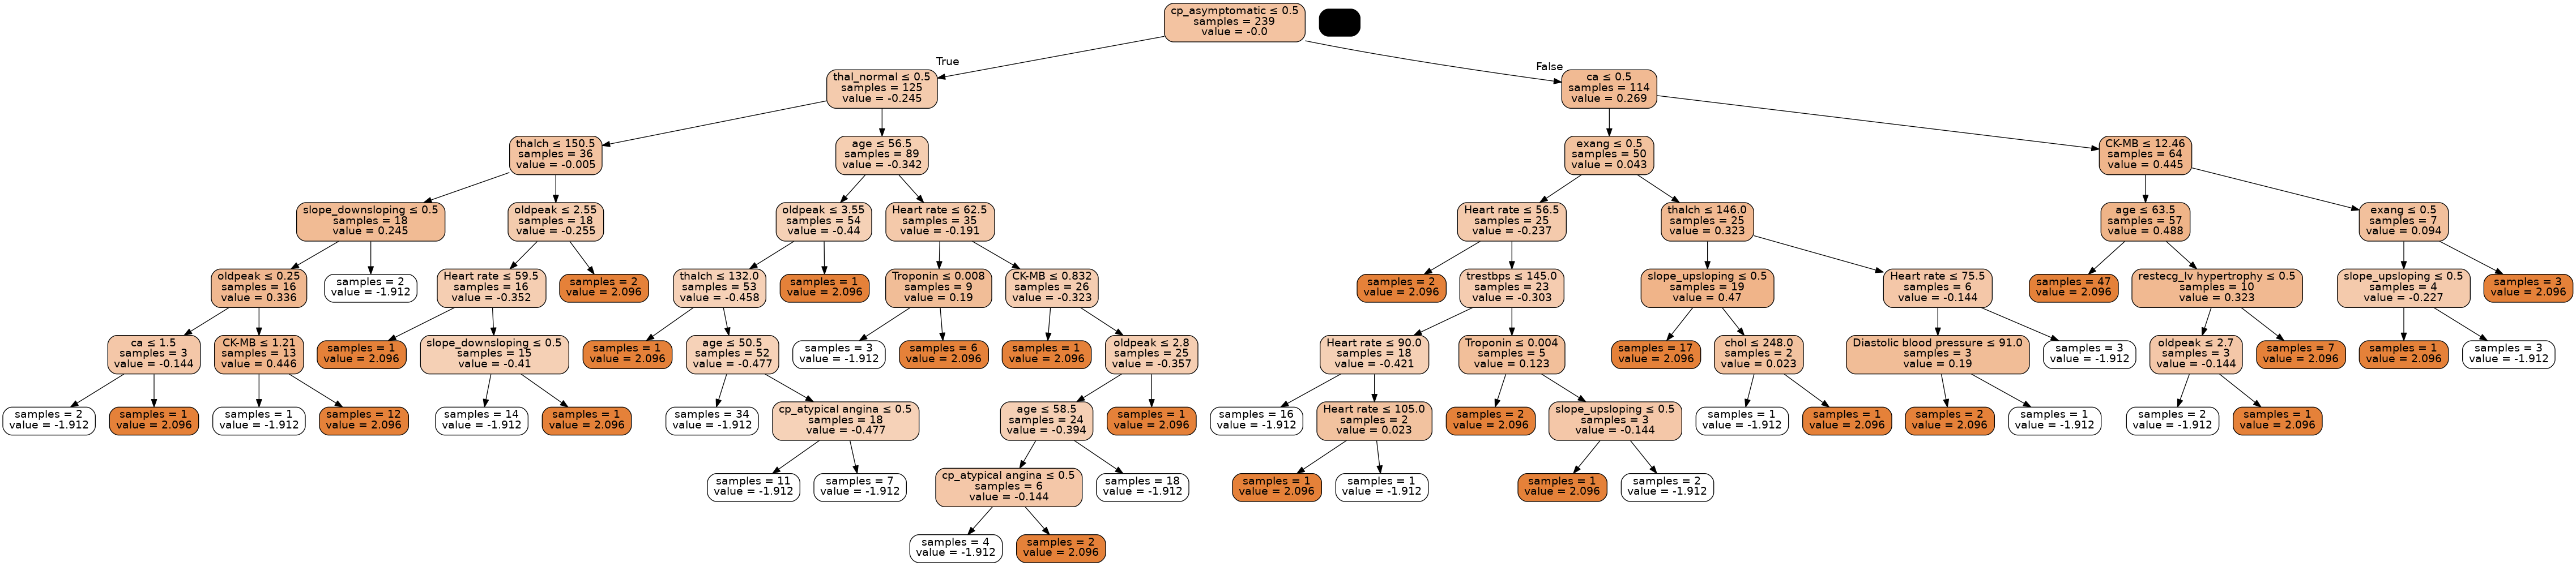

In [ ]:
# Display an example tree from the ensemble
tree = clf.estimators_[0,0]

from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image

dot_data = export_graphviz(
    tree, out_file = None, filled = True, rounded = True,
    special_characters = True,
    proportion = False, impurity = False,
    feature_names = X_train.columns)

graph = graph_from_dot_data(dot_data)
png=graph.create_png()
from pathlib import Path

Path('./out.png').write_bytes(png)
Image(png)

Training Accuracy: 1.0
Number of leaves: 41
Number of nodes: 81


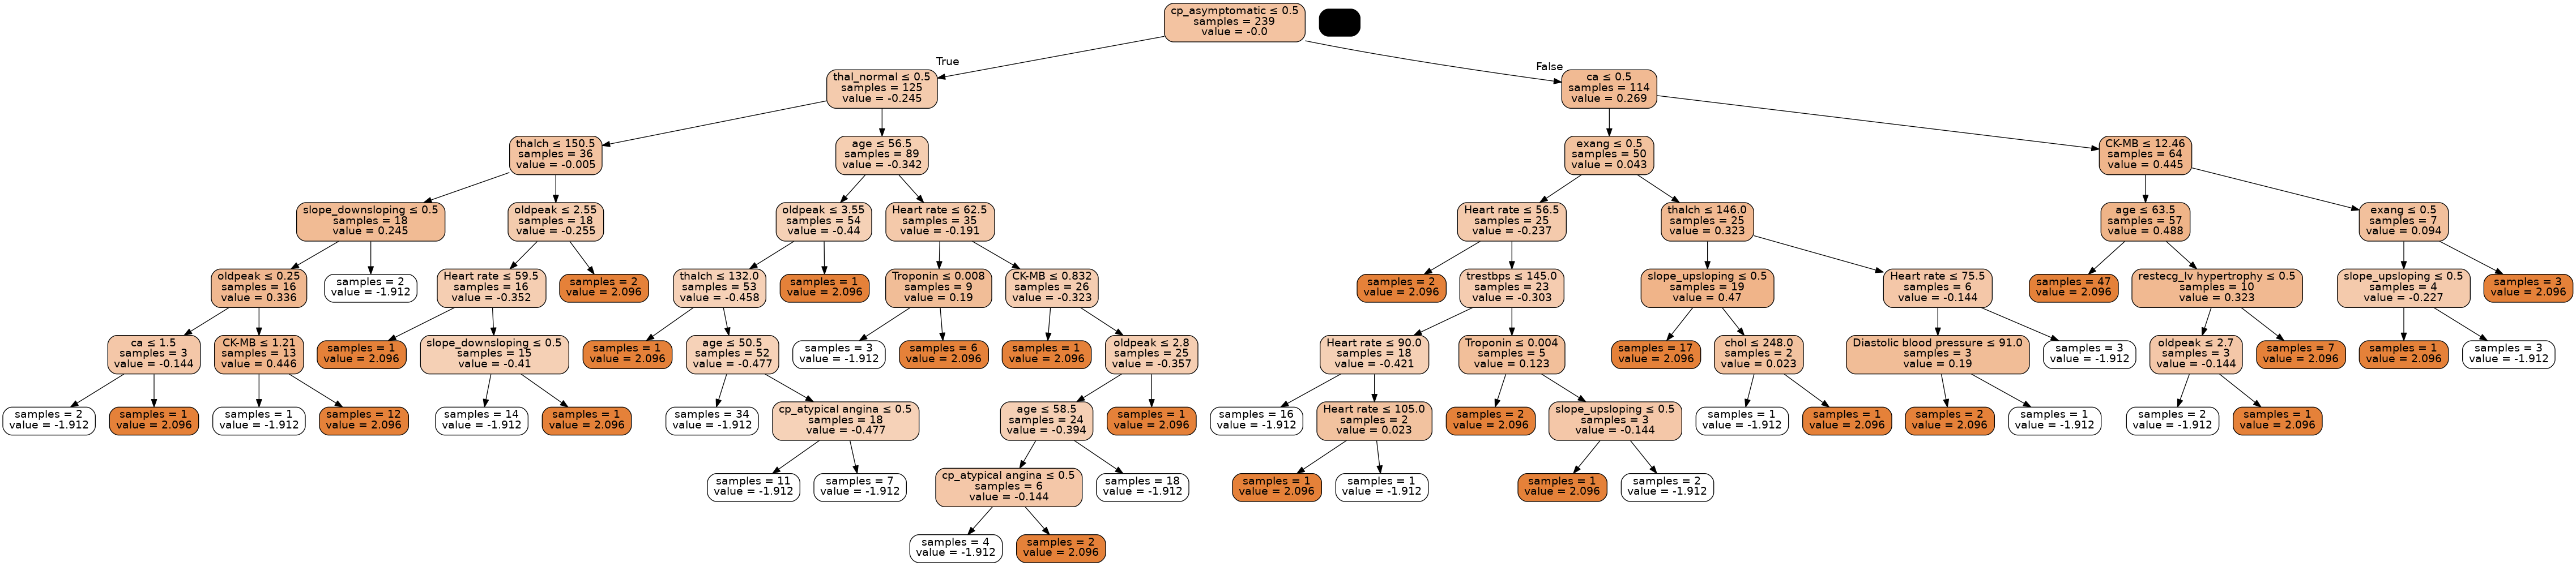

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image
from pathlib import Path

# Hyperparameters for the Gradient Boosting Classifier
n_estimators = 250    # Number of boosting stages
max_depth = 10        # Maximum depth of the individual estimators
learning_rate = 0.001 # Step size shrinkage

# Initialize and train the classifier
gb_clf = GradientBoostingClassifier(
    loss='log_loss',
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    max_depth=max_depth,
    random_state=42
)

# Fit the model on the training data
gb_clf.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = gb_clf.predict(X_train)

# Evaluate the model
train_accuracy = gb_clf.score(X_train, y_train)
print(f'Training Accuracy: {train_accuracy}')

# Display an example tree from the ensemble
tree = gb_clf.estimators_[0, 0]

# Get number of leaves and nodes
num_leaves = tree.get_n_leaves()
num_nodes = tree.tree_.node_count

print(f'Number of leaves: {num_leaves}')
print(f'Number of nodes: {num_nodes}')

# Generate and display the tree visualization
dot_data = export_graphviz(
    tree, out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False,
    feature_names=X_train.columns)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()

Path('./out.png').write_bytes(png)
Image(png)



array([1., 1.])

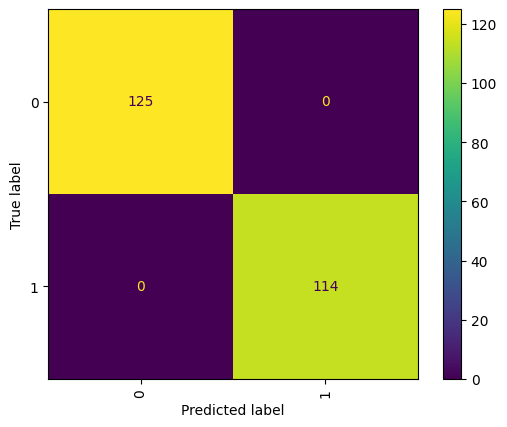

In [ ]:
# Generate a confusion matrix for the GBDT
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_train, y_pred)
ConfusionMatrixDisplay.from_estimator(clf,X_train,y_train,display_labels=clf.classes_,xticks_rotation='vertical')
matrix.diagonal()/matrix.sum(axis=1)

In [ ]:
# Calculate precision, recall and f1
from sklearn.metrics import precision_recall_fscore_support
prec, rec, fbeta, supp = precision_recall_fscore_support(y_test, y_test_pred)

In [ ]:
classes = clf.classes_
d = {'Class':classes,'Precision':prec,'Recall':rec,'f1':fbeta,'Support':supp}
scores_df = pd.DataFrame(d)
display(scores_df)

,Class,Precision,Recall,f1,Support
0,0,0.771429,0.771429,0.771429,35
1,1,0.680000,0.680000,0.680000,25


In [ ]:
# Create a df from the thresholded GOSDT training set
xt_df = pd.DataFrame(X_train_g)
xt_df = pd.concat([xt_df,y_train_g], axis = 1)
xt_df

,age<=40.5,age<=45.5,age<=47.5,age<=54.5,age<=64.5,trestbps<=107.0,trestbps<=119.0,chol<=183.0,chol<=303.5,chol<=318.5,...,Troponin<=1.824999988079071,Troponin<=2.924999952316284,sex_Female<=0.5,sex_Male<=0.5,cp_asymptomatic<=0.5,cp_non-anginal<=0.5,slope_flat<=0.5,thal_normal<=0.5,Diastolic blood pressure<=99.5,num
157,0,0,0,0,1,0,0,0,1,1,...,1,1,1,0,0,1,0,1,1,1
253,0,0,0,0,0,1,1,0,1,1,...,1,1,0,1,0,1,1,0,1,0
221,0,0,0,0,1,0,1,0,1,1,...,1,1,0,1,0,1,0,0,1,1
208,1,1,1,1,1,0,0,0,1,1,...,1,1,1,0,1,1,0,1,1,1
22,0,0,0,0,1,0,0,0,1,1,...,1,1,1,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,0,0,0,0,0,0,0,0,1,1,...,1,1,1,0,1,0,0,1,1,1
158,0,0,0,0,0,0,1,0,1,1,...,1,1,1,0,1,0,1,1,1,0
250,0,0,0,1,1,0,0,0,1,1,...,1,1,0,1,1,0,1,0,1,0
201,0,1,1,1,1,0,1,0,1,1,...,1,1,1,0,0,1,1,1,1,0


In [ ]:
xt_df
xt_df.to_csv('output.csv', index=False)

In [ ]:
# Import RID, all RID files must be in the same level of the directory as the Jupyter Notebook
# RID is very resource hungry, make sure you have enough compute to support your lam and eps!
from rashomon_importance_distribution import RashomonImportanceDistribution
start_time = time.time()
# Map the threshold columns, thresholds from the same feature are grouped to calculate feature importance
mapping={
    0: [0],        # restbps <= 119.0
    1: [1],        # exang <= 0.5
    2: [2, 3, 4],  # oldpeak conditions
    3: [5],        # ca <= 0.5
    4: [6],        # Systolic blood pressure <= 129.5
    5: [7, 21],    # Diastolic blood pressure <= 82.5 and <= 62.5
    6: [8, 9],     # Blood sugar conditions
    7: [10, 11, 12],  # CK-MB conditions
    8: [13, 14, 15],  # Troponin conditions
    9: [16],       # sex_Female <= 0.5
    10: [17],      # cp_asymptomatic <= 0.5
    11: [18],      # slope_flat <= 0.5
    12: [19],      # thal_normal <= 0.5
}



# Set parameters for RID, db is depth budget, lam is the lambda or sparsity hyperparameter,
# eps is the epsilon or confidence range for model inclusion around the optimal model
RID = RashomonImportanceDistribution(
    input_df = xt_df,
    binning_map = mapping,
    db = 0,
    lam = 0.05,
    eps = 0.010,
    vi_metric = 'sub_mr',
    dataset_name = 'heart_diseases_guessees',
    n_resamples = 10,
    verbose = True,
    max_par_for_gosdt = 3
)

# Print the variable importance metrics from RID
for v in range(15):
    print(f'Variable {v} ------------')

    print('Box and whiskers mean:', RID.mean(v))
    print('Box and whiskers median:', RID.median(v))
    print('Box and whiskers range:', RID.bwr(v))
    print('--- %s seconds' % (time.time()-start_time))

Rashomon set has already been computed
Rashomon set has already been computedRashomon set has already been computedRashomon set has already been computed


Rashomon set has already been computed
Rashomon set has already been computedRashomon set has already been computed

Rashomon set has already been computed
Rashomon set has already been computed
Rashomon set has already been computed
Completed final processing in 2.956390380859375e-05 seconds
Processing ours with counts
Starting var 0
Starting var 1
Starting var 2
Starting var 3
Starting var 4
Starting var 5
Starting var 6
Starting var 7
Starting var 8
Starting var 9
Starting var 10
Starting var 11
Starting var 12
Variable 0 ------------
Box and whiskers mean: 7.686159401251084e-17
Box and whiskers median: 1.1102230246251565e-16
Box and whiskers range: (1.1102230246251565e-16, 1.1102230246251565e-16)
--- 0.9985010623931885 seconds
Variable 1 ------------
Box and whiskers mean: 7.686159401251084e-17
Box and whiskers median: 1.1102230

KeyError: 13

In [ ]:
# Rerun GOSDT specifying important features to keep to compare to the initial model
dfr = pd.read_csv("heart_diseases_guesses.csv")

X = dfr.drop(columns=['num','Blood sugar', 'Diastolic blood pressure', 'Heart rate', 'sex_Male', 'thalch', 'Troponin', 'fbs', 'CK-MB', 'thal_reversable defect', 'slope_downsloping', 'restecg_lv hypertrophy', 'dataset_VA Long Beach', 'cp_atypical angina', 'thal_fixed defect', 'restecg_normal', 'dataset_Cleveland', 'cp_typical angina', 'slope_upsloping', 'dataset_Hungary', 'slope_flat', 'sex_Female', 'exang', 'restecg_st-t abnormality'])
y = dfr['num']
h = dfr.columns[:-1]

print(X)


     age  trestbps  chol  oldpeak  ca  Systolic blood pressure  \
0     63       145   233      2.3   0                      160   
1     67       160   286      1.5   3                       98   
2     67       120   229      2.6   2                      160   
3     37       130   250      3.5   0                      120   
4     41       130   204      1.4   0                      112   
..   ...       ...   ...      ...  ..                      ...   
294   68       144   193      3.4   2                       96   
295   57       130   131      1.2   1                      119   
296   57       130   236      0.0   1                      119   
297   47       150   226      1.5   0                       65   
298   56       120   100      1.5   0                      126   

     cp_asymptomatic  cp_non-anginal  thal_normal  
0                  0               0            0  
1                  1               0            1  
2                  1               0            0  

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)


NameError: name 'train_test_split' is not defined

In [ ]:
import pandas as pd
import time
import pathlib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import gosdt  # Assuming you have the GOSDT library

# GBDT parameters for threshold and lower bound guesses
n_est = 200
max_depth = 1

# Guess thresholds
X = pd.DataFrame(X_train, columns=h)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Guess thresholds
X_train_g, thresholds, header, threshold_guess_time = compute_thresholds(X_train, y_train, n_est, max_depth)
y_train_g = pd.DataFrame(y_train)

# Guess lower bound using Gradient Boosting
start_time = time.time()
clf = GradientBoostingClassifier(n_estimators=n_est, max_depth=max_depth, random_state=42)
clf.fit(X_train_g, y_train_g.values.flatten())
warm_labels = clf.predict(X_train_g)
elapsed_time = time.time() - start_time
lb_time = elapsed_time

# Save the labels from lower bound guesses to a tmp file
labelsdir = pathlib.Path('/tmp/warm_lb_labels')
labelsdir.mkdir(exist_ok=True, parents=True)
labelpath = labelsdir / 'warm_label.tmp'
labelpath = str(labelpath)
pd.DataFrame(warm_labels, columns=["class_labels"]).to_csv(labelpath, header="class_labels", index=None)

# Train GOSDT model
config = {
    "regularization": 0.001,
    "depth_budget": 3,
    "warm_LB": True,
    "path_to_labels": labelpath,
    "similar_support": False
}

model = gosdt.GOSDT(config)
model.fit(X_train_g, y_train_g)

print("Evaluating the model, extracting tree and scores...\n", flush=True)

# Get the results for training accuracy
train_acc = model.score(X_train_g, y_train_g)

# Threshold X_test using the same black-box derived thresholds as the training set
X_test = cut(X_test, thresholds)  # Apply same thresholds to the test set
X_test = X_test[X_train_g.columns]  # Remove unused thresholds

# Calculate test accuracy
test_acc = model.score(X_test, y_test)

# Get number of leaves and nodes in the model
n_leaves = model.leaves()
n_nodes = model.nodes()

# Calculate total training time
fulltime = time.time() - start_time

# Print training time and model structure
print("Model training time: {}".format(fulltime))
print("Training accuracy: {}".format(train_acc))
print("Test accuracy: {}".format(test_acc))
print("# of leaves: {}".format(n_leaves))
print("# of nodes: {}".format(n_nodes))

# Print the confusion matrix of the model (if available)
print(model.confusion)
print(model.tree)

# Predicting for training and test sets
y_train_pred = model.predict(X_train_g)  # Predictions for the training set
y_test_pred = model.predict(X_test)     # Predictions for the test set

# Calculate precision, recall, F1 score, and support for the training set
train_prec, train_rec, train_fbeta, train_supp = precision_recall_fscore_support(
    y_train_g, y_train_pred, average='binary'
)

# Calculate precision, recall, F1 score, and support for the test set
test_prec, test_rec, test_fbeta, test_supp = precision_recall_fscore_support(
    y_test, y_test_pred, average='binary'
)

# Print the results for training and test sets
print(f"Training Precision: {train_prec:.4f}")
print(f"Training Recall: {train_rec:.4f}")
print(f"Training F1 Score: {train_fbeta:.4f}")
print(f"Training Support: {train_supp}")

print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1 Score: {test_fbeta:.4f}")
print(f"Test Support: {test_supp}")

# Confusion Matrix for Training set
train_cm = confusion_matrix(y_train_g, y_train_pred)
print("\nTraining Set Confusion Matrix:")
print(train_cm)

# Confusion Matrix for Test set
test_cm = confusion_matrix(y_test, y_test_pred)
print("\nTest Set Confusion Matrix:")
print(test_cm)


X_train shape: (104, 9)
y_train shape: (104,)
gosdt reported successful execution
training completed. 0.000/0.000/0.001 (user, system, wall), mem=0 MB
bounds: [0.163462..0.163462] (0.000000) loss=0.125000, iterations=45
Evaluating the model, extracting tree and scores...

Regularization smaller than 1/(num_samples) - this may lead to longer training time if not adjusted.
Regularization increased to 1/(num_samples) = 0. To allow regularization below this, set allow_small_reg to true
Model training time: 0.10895323753356934
Training accuracy: 0.875
Test accuracy: 0.7444444444444445
# of leaves: 4
# of nodes: 7
<bound method GOSDT.confusion of <gosdt.model.gosdt.GOSDT object at 0x7fd93d7bbcd0>>
if cp_asymptomatic<=0.5 = 1 and thal_normal<=0.5 = 1 then:
    predicted class: 0
    misclassification penalty: 0.029
    complexity penalty: 0.01

else if cp_asymptomatic<=0.5 != 1 and thal_normal<=0.5 = 1 then:
    predicted class: 1
    misclassification penalty: 0.019
    complexity penalty: 0

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Predicting for training and test sets
y_train_pred = model.predict(X_train_g)  # Predictions for the training set
y_test_pred = model.predict(X_test)     # Predictions for the test set

# Calculate precision, recall, F1 score, and support for the training set
prec, rec, fbeta, supp = precision_recall_fscore_support(
    y_train_g, y_train_pred, average='binary'
)

# Calculate precision, recall, F1 score, and support for the test set
prec2, rec2, fbeta2, supp2 = precision_recall_fscore_support(
    y_test, y_test_pred, average='binary'
)

# Print the results for training and test sets
print(f"Training Precision: {prec:.4f}")
print(f"Training Recall: {rec:.4f}")
print(f"Training F1 Score: {fbeta:.4f}")
print(f"Training Support: {supp}")

print(f"Test Precision: {prec2:.4f}")
print(f"Test Recall: {rec2:.4f}")
print(f"Test F1 Score: {fbeta2:.4f}")
print(f"Test Support: {supp2}")

Training Precision: 0.8727
Training Recall: 0.8421
Training F1 Score: 0.8571
Training Support: None
Test Precision: 0.7241
Test Recall: 0.8400
Test F1 Score: 0.7778
Test Support: None
